🚀 正在重建完整数据管道...

📥 [1/3] 正在获取 Riot 全英雄名录...
✅ Riot 数据就绪！共 172 个英雄。

🕵️‍♂️ [2/3] 正在去 B 站重新进货 (仅演示前 20 个)...
   📺 九尾妖狐: 5480718 播放
   📺 牛头酋长: 6963609 播放
   📺 铁血狼母: 4001546 播放
   📺 殇之木乃伊: 1361252 播放
   📺 寒冰射手: 16336294 播放
   📺 铸星龙王: 12129091 播放
   📺 双界灵兔: 3559029 播放
   📺 沙漠皇帝: 8385426 播放
   📺 星界游神: 3993477 播放
   📺 狂厄蔷薇: 5088784 播放
✅ Bilibili 数据就绪！

🎨 [3/3] 正在绘图...


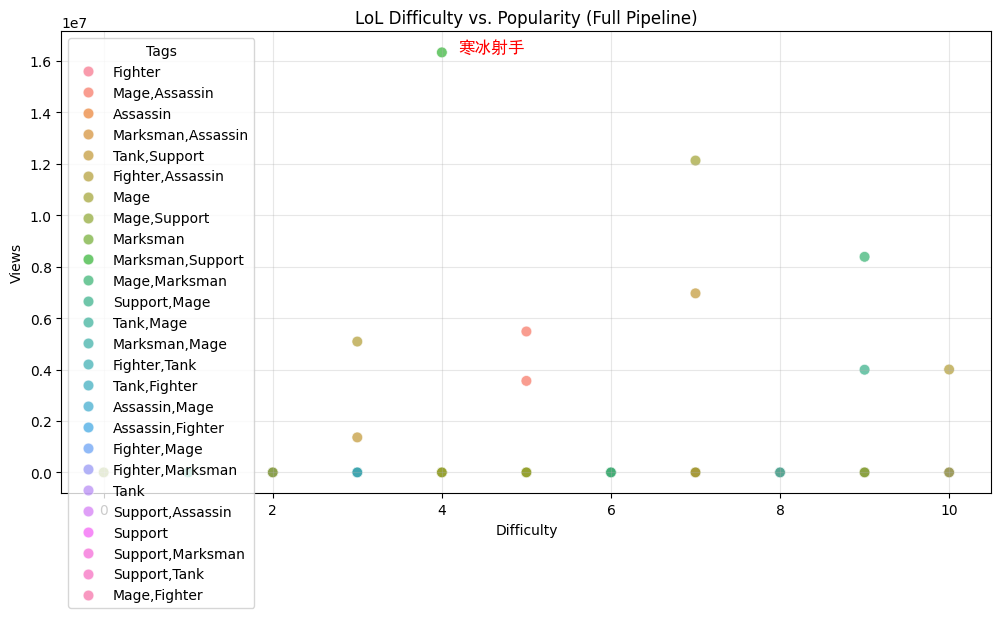

In [1]:
import requests
import pandas as pd
import sqlite3
import time
import random
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 初始化数据库
conn = sqlite3.connect('lol_analysis.db')
print("🚀 正在重建完整数据管道...")

# ==========================================
# 📦 步骤 A: 获取 Riot 英雄数据 (主表)
# ==========================================
print("\n📥 [1/3] 正在获取 Riot 全英雄名录...")
try:
    VERSION_URL = "https://ddragon.leagueoflegends.com/api/versions.json"
    latest_version = requests.get(VERSION_URL).json()[0]
    CHAMP_URL = f"https://ddragon.leagueoflegends.com/cdn/{latest_version}/data/zh_CN/champion.json"
    champ_data = requests.get(CHAMP_URL).json()['data']

    difficulty_list = []
    # 我们只抓前 20 个英雄做演示，为了节省时间！
    # (在真实项目中，你会去掉 [:20] 来跑全量)
    target_champs = [] 
    
    for en_name, data in champ_data.items():
        difficulty_list.append({
            "Champion": data['name'],
            "Difficulty": data['info']['difficulty'],
            "Tags": ",".join(data['tags'])
        })
        target_champs.append({"name": data['name'], "title": data['title']})

    # 存入 riot_stats 表
    df_riot = pd.DataFrame(difficulty_list)
    df_riot.to_sql('riot_stats', conn, if_exists='replace', index=False)
    print(f"✅ Riot 数据就绪！共 {len(df_riot)} 个英雄。")

except Exception as e:
    print(f"❌ Riot 数据出错: {e}")

# ==========================================
# 📺 步骤 B: 获取 Bilibili 播放数据 (副表)
# ==========================================
print("\n🕵️‍♂️ [2/3] 正在去 B 站重新进货 (仅演示前 20 个)...")
# 我们只取前 20 个英雄去搜，避免等待太久
demo_champs = target_champs[:20] 

bili_stats = []
headers = {
    "User-Agent": "Mozilla/5.0",
    "Cookie": "buvid3=infoc;"
}

for champ in demo_champs:
    search_keyword = champ['name']
    try:
        # 简单休眠防止封 IP
        time.sleep(0.5)
        
        url = "https://api.bilibili.com/x/web-interface/search/type"
        params = {"keyword": f"LOL {search_keyword}", "search_type": "video", "order": "click"}
        
        resp = requests.get(url, headers=headers, params=params, timeout=3)
        if resp.status_code == 200:
            data = resp.json()
            total_views = 0
            if data['code'] == 0 and 'data' in data and 'result' in data['data']:
                video_list = data['data']['result']
                if isinstance(video_list, list):
                    for v in video_list[:5]:
                        views = v.get('play') or v.get('stat', {}).get('view') or 0
                        total_views += int(views)
            
            bili_stats.append({
                "Champion": champ['name'],
                "Bili_Top5_Views": total_views
            })
            print(f"   📺 {search_keyword}: {total_views} 播放")
            
    except Exception:
        pass # 演示代码，出错先跳过

# 存入 bili_hot_champs 表
df_bili = pd.DataFrame(bili_stats)
df_bili.to_sql('bili_hot_champs', conn, if_exists='replace', index=False)
print("✅ Bilibili 数据就绪！")

# ==========================================
# 📊 步骤 C: 融合与画图 (LEFT JOIN + COALESCE)
# ==========================================
print("\n🎨 [3/3] 正在绘图...")

sql_full = """
SELECT 
    r.Champion,
    r.Difficulty,
    COALESCE(b.Bili_Top5_Views, 0) as Views, 
    r.Tags
FROM riot_stats r
LEFT JOIN bili_hot_champs b ON r.Champion = b.Champion
"""

df_full = pd.read_sql(sql_full, conn)

plt.figure(figsize=(12, 6))
# 这一次，数据涵盖了我们抓取的所有英雄
sns.scatterplot(data=df_full, x="Difficulty", y="Views", hue="Tags", s=60, alpha=0.7)

# 标出最火的
if not df_full.empty:
    top_hero = df_full.loc[df_full['Views'].idxmax()]
    if top_hero.Views > 0:
        plt.text(top_hero.Difficulty+0.2, top_hero.Views, top_hero.Champion, fontproperties='SimHei', fontsize=12, color='red')

plt.title("LoL Difficulty vs. Popularity (Full Pipeline)")
plt.grid(True, alpha=0.3)
plt.show()

conn.close()

In [4]:
import sqlite3
import pandas as pd

# 1. 🚑 重新拨通电话：连接数据库
conn = sqlite3.connect('lol_analysis.db')

# 2. 定义查询语句
sql_avg = """
SELECT 
    Difficulty, 
    AVG(COALESCE(b.Bili_Top5_Views, 0)) AS Avg_Views
FROM riot_stats r
LEFT JOIN bili_hot_champs b ON r.Champion = b.Champion
GROUP BY Difficulty
ORDER BY Avg_Views DESC
"""

# 3. 运行查询
print("📊 各难度平均播放量排行榜：")
df_avg = pd.read_sql(sql_avg, conn)
print(df_avg)

# 4. 查完记得再次挂断 (可选，但在本地开发是好习惯)
conn.close()

📊 各难度平均播放量排行榜：
    Difficulty     Avg_Views
0            9  1.125355e+06
1            7  8.678500e+05
2            4  6.806789e+05
3            3  4.607169e+05
4           10  4.446162e+05
5            5  2.739317e+05
6            8  0.000000e+00
7            6  0.000000e+00
8            2  0.000000e+00
9            1  0.000000e+00
10           0  0.000000e+00


In [9]:
conn = sqlite3.connect('lol_analysis.db')
sql_new = """
WITH Ranked_Heroes AS (

    SELECT r.Champion, Difficulty, COALESCE(b.Bili_Top5_Views, 0) AS Views, RANK() OVER (

    PARTITION BY Difficulty   -- 按难度切分队伍

    ORDER BY COALESCE(b.Bili_Top5_Views, 0) DESC       -- 按播放量从高到低排队

) as rk                       -- 给这个排名起个别名叫 rk

FROM riot_stats r

LEFT JOIN bili_hot_champs b ON r.Champion = b.Champion

)

SELECT * FROM Ranked_Heroes 

WHERE rk = 1;
"""
df_new = pd.read_sql(sql_new, conn)
print(df_new)

   Champion  Difficulty    Views  rk
0        影哨           0        0   1
1      镕铁少女           0        0   1
2      星籁歌姬           0        0   1
3      愁云使者           0        0   1
4      赏金猎人           1        0   1
..      ...         ...      ...  ..
60     远古巫灵           8        0   1
61     封魔剑魂           8        0   1
62     生化魔人           8        0   1
63     沙漠皇帝           9  8385426   1
64     铁血狼母          10  4001546   1

[65 rows x 4 columns]
